In [2]:
from zipfile import ZipFile
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from geopandas import GeoDataFrame
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
from geopy.distance import geodesic

In [35]:
import pandas as pd
import zipfile
import re
import os 

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')

# Loading incident data 
zf = zipfile.ZipFile('Data_incidents.csv.zip') 
df = pd.read_csv(zf.open('Data_incidents.csv.zip'))


In [36]:
df['Mass Shooting'].describe()

count     239351
unique         2
top        False
freq      237714
Name: Mass Shooting, dtype: object

In [6]:
#for col in df.columns: 
 #   print(col)
    
#df.isnull().sum()

In [7]:
# Loading law data 
df_law = pd.read_csv('gun_law_merge.csv', sep = ';')

# Renaming the state column
df_law.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [8]:
#import fiona; help(fiona.open)

In [9]:
# Loading map data 

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/maps/states_21basic')

usa = gpd.read_file('states.shp')
usa.head(2)
#len(usa.STATE_NAME.unique())

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."


### Finding distances between mass shootings and incidents 

In [10]:
#df['origin_latitude'] = np.nan
#df['origin_longitude'] = np.nan

# Generating origin points 

for i in range(len(df)): 
    if df['Mass Shooting'].iloc[i] == True: 
        df['origin_latitude'].iloc[i] = df['latitude'].iloc[i]
        df['origin_longitude'].iloc[i] = df['longitude'].iloc[i]

df['origin'] = df[['origin_latitude', 'origin_longitude']].apply(lambda x: ','.join(x.fillna('').map(str)), axis=1)

df['dist_latitude'] = np.nan
df['dist_longitude'] = np.nan

# Generating distance points

for i in range(len(df)): 
    if df['Mass Shooting'].iloc[i] == False: 
        df['dist_latitude'].iloc[i] = df['latitude'].iloc[i]
        df['dist_longitude'].iloc[i] = df['longitude'].iloc[i]

df['dist'] = df[['dist_latitude', 'dist_longitude']].apply(lambda x: ','.join(x.fillna('').map(str)), axis=1)

origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613

### Excluding Alaska and Hawaii

In [11]:
usa_49 = usa[1:50]
print(usa.STATE_NAME.unique())
usa_49.STATE_NAME.unique()

['Hawaii' 'Washington' 'Montana' 'Maine' 'North Dakota' 'South Dakota'
 'Wyoming' 'Wisconsin' 'Idaho' 'Vermont' 'Minnesota' 'Oregon'
 'New Hampshire' 'Iowa' 'Massachusetts' 'Nebraska' 'New York'
 'Pennsylvania' 'Connecticut' 'Rhode Island' 'New Jersey' 'Indiana'
 'Nevada' 'Utah' 'California' 'Ohio' 'Illinois' 'District of Columbia'
 'Delaware' 'West Virginia' 'Maryland' 'Colorado' 'Kentucky' 'Kansas'
 'Virginia' 'Missouri' 'Arizona' 'Oklahoma' 'North Carolina' 'Tennessee'
 'Texas' 'New Mexico' 'Alabama' 'Mississippi' 'Georgia' 'South Carolina'
 'Arkansas' 'Louisiana' 'Florida' 'Michigan' 'Alaska']


array(['Washington', 'Montana', 'Maine', 'North Dakota', 'South Dakota',
       'Wyoming', 'Wisconsin', 'Idaho', 'Vermont', 'Minnesota', 'Oregon',
       'New Hampshire', 'Iowa', 'Massachusetts', 'Nebraska', 'New York',
       'Pennsylvania', 'Connecticut', 'Rhode Island', 'New Jersey',
       'Indiana', 'Nevada', 'Utah', 'California', 'Ohio', 'Illinois',
       'District of Columbia', 'Delaware', 'West Virginia', 'Maryland',
       'Colorado', 'Kentucky', 'Kansas', 'Virginia', 'Missouri',
       'Arizona', 'Oklahoma', 'North Carolina', 'Tennessee', 'Texas',
       'New Mexico', 'Alabama', 'Mississippi', 'Georgia',
       'South Carolina', 'Arkansas', 'Louisiana', 'Florida', 'Michigan'],
      dtype=object)

### Grouping the incident data by sum and count depending on what we want

In [12]:
df_group_count=df.groupby('state').count().reset_index()
df_group_incidents_count = df_group_count[['state','incident_id']]
df_group_sum = df.groupby('state').sum().reset_index()
df_group_incidents_sum = df_group_sum[['state','n_killed','n_injured']]
df_group_incidents_sum.head(1)

# Dataset with N_incident, n_killed and n_injured
df_group_incidents= df_group_incidents_sum.set_index('state').join(df_group_incidents_count.set_index('state')).reset_index()

### Grouping the incident data by number of true in incident characteristics

In [13]:
df_IC = df.iloc[:, [3] + list(range(30,139))]
df_IC_group = df_IC.groupby('state').sum().reset_index()

#for col in df_IC_group.columns: 
 #   print(col)

### Editing law data

In [14]:
laws =['State permit required to purchase? - Long guns',
'Firearm registration? - Long guns',
'Owner license required? - Long guns',
'Assault weapon law? - Long guns',
'NFA weapons restricted? - Long guns',
'Background checks required for private sales? - Long guns',
'Magazine Capacity Restriction? - Long guns',
'Red flag law? - Long guns',
'State permit required to purchase? - Handguns',
'Firearm registration? - Handguns',
'Owner license required? - Handguns',
'Assault weapon law? - Handguns',
'NFA weapons restricted? - Handguns',
'Background checks required for private sales? - Handguns',
'Magazine Capacity Restriction? - Handguns',
'Red flag law? - Handguns']

laws_longguns = laws[0:8]
laws_handguns = laws[8:16]

print(len(laws_longguns))
print(len(laws_handguns))


#count how many laws on handguns and longgund each state has

df_law['handgun_laws - count'] = df_law.loc[:, laws_handguns].sum(axis=1)
df_law['longgun_laws - count'] = df_law.loc[:, laws_longguns].sum(axis=1)
df_law.head(1)

8
8


,state,State permit required to purchase? - Long guns,Firearm registration? - Long guns,Owner license required? - Long guns,Assault weapon law? - Long guns,NFA weapons restricted? - Long guns,Background checks required for private sales? - Long guns,Magazine Capacity Restriction? - Long guns,Red flag law? - Long guns,State permit required to purchase? - Handguns,Firearm registration? - Handguns,Owner license required? - Handguns,Assault weapon law? - Handguns,NFA weapons restricted? - Handguns,Background checks required for private sales? - Handguns,Magazine Capacity Restriction? - Handguns,Red flag law? - Handguns,handgun_laws - count,longgun_laws - count
0,Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Merging the map data, incident data and law data

In [33]:
merged_group = usa_49.set_index('STATE_NAME').join(df_group_incidents.set_index('state')).reset_index()
merged_group_all = merged_group.set_index('STATE_NAME').join(df_IC_group.set_index('state')).join(df_law.set_index('state'))

# Renaming incident_id to N_incident
merged_group_all.rename(columns={'incident_id':'N_incident'}, inplace=True)

In [31]:
merged_group_all['NFA weapons restricted? - Handguns']
merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].describe()
#merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','NFA weapons restricted? - Handguns']].sum()

,N_incident,n_killed,n_injured,Child injured,Mass Shooting,Child killed self,Hate crime,NFA weapons restricted? - Handguns
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,46.000000
mean,4857.938776,1227.306122,2408.000000,21.102041,33.387755,3.326531,2.081633,0.217391
std,4274.192138,1254.442509,2565.497012,22.259123,40.229972,4.084461,2.970948,0.417029
min,472.000000,57.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1651.000000,282.000000,674.000000,4.000000,5.000000,0.000000,0.000000,0.000000
50%,3434.000000,853.000000,1415.000000,10.000000,17.000000,2.000000,1.000000,0.000000
75%,6631.000000,1705.000000,3566.000000,39.000000,47.000000,5.000000,2.000000,0.000000
max,17556.000000,5562.000000,13514.000000,83.000000,194.000000,19.000000,15.000000,1.000000


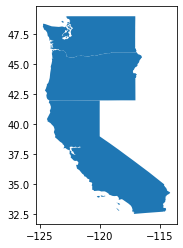

In [37]:
## Code for plotting specific regions (can also be used for states etc)
merged_group[merged_group.SUB_REGION == 'Pacific'].plot()

## Plotting point map

### Excluiding Alaska and Hawaii from the map

df = df.drop(df[(df.state == 'Alaska') & (df.state == 'Hawaii')].index)


In [38]:
df_49 = df.drop(df.index[(df.state == 'Alaska')])
df_48 = df_49.drop(df_49.index[(df_49.state == 'Hawaii')])
df_47 = df_48.drop(df_48.index[(df_48.state == 'District of Columbia')])
print(len(df))
print(len(df_49))
print(len(df_48))
print(len(df_47))

239677
238328
238039
234844


In [39]:
df_47.state.unique()

array(['Pennsylvania', 'California', 'Ohio', 'Colorado', 'North Carolina',
       'Oklahoma', 'New Mexico', 'Louisiana', 'Maryland', 'Tennessee',
       'Missouri', 'Illinois', 'Delaware', 'Utah', 'Michigan', 'Georgia',
       'Indiana', 'Mississippi', 'New York', 'Florida', 'Washington',
       'South Carolina', 'Arizona', 'Kentucky', 'New Jersey', 'Virginia',
       'Wisconsin', 'Rhode Island', 'Texas', 'Alabama', 'Kansas',
       'Connecticut', 'West Virginia', 'Minnesota', 'Nevada', 'Nebraska',
       'Massachusetts', 'New Hampshire', 'Iowa', 'Arkansas', 'Idaho',
       'Oregon', 'Wyoming', 'Maine', 'North Dakota', 'Montana', 'Vermont',
       'South Dakota'], dtype=object)

In [40]:
geometry = [Point(xy) for xy in zip(df_47['longitude'], df_47['latitude'])]

In [41]:
crs = {'init': 'epsg:4269'}
geo_df = gpd.GeoDataFrame(df_47, crs = crs, geometry = geometry)
geo_df.head(1)

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,...,Child injured,Gun buy back action,Terrorism Involvement,Officer Involved Shooting - Accidental discharge - no injury required,Mistaken ID,Officer Involved Shooting - subject/suspect/perpetrator suicide by cop,Ghost gun,Political Violence,NAV,geometry
0,0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,...,False,False,False,False,False,False,False,False,False,POINT (-79.85590 40.34670)


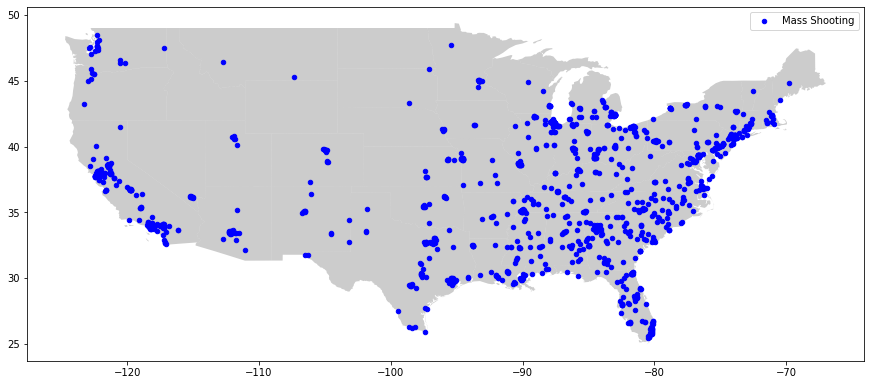

In [42]:
fig, ax = plt.subplots(figsize = (15,15))
usa_49.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Mass Shooting')
#geo_df[geo_df['incident_id']>= 0].plot(ax = ax, markersize = 20, color = 'red', marker = 'o', label = 'Incident')
plt.legend()

## Plotting Heatmap with points

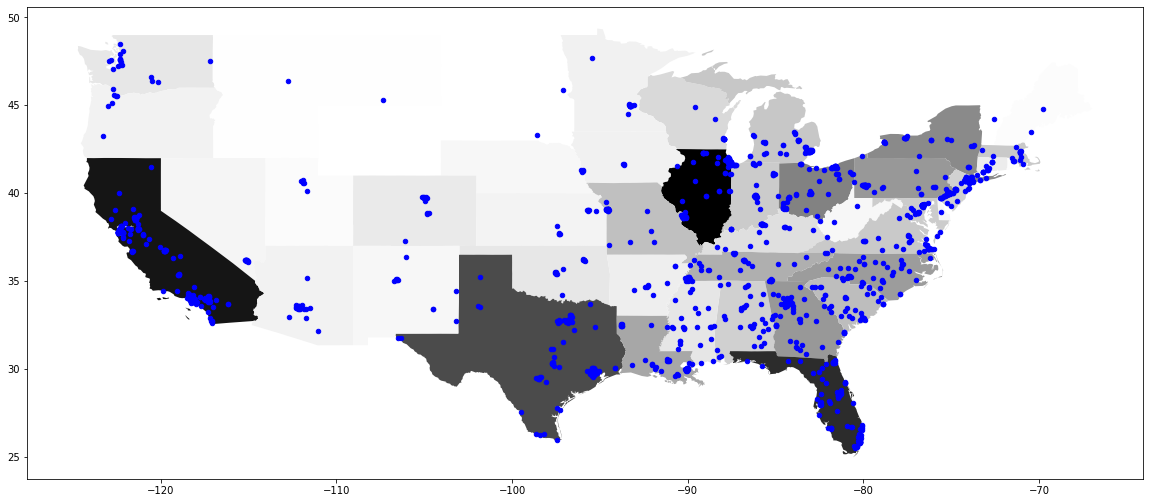

In [43]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'N_incident'

# set the range for the choropleth
vmin, vmax = 472, 17556

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 15))
merged_group_all.plot(column=variable, cmap='Greys', linewidth=0.8, ax = ax)
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Mass Shooting')

In [44]:
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

# add legend

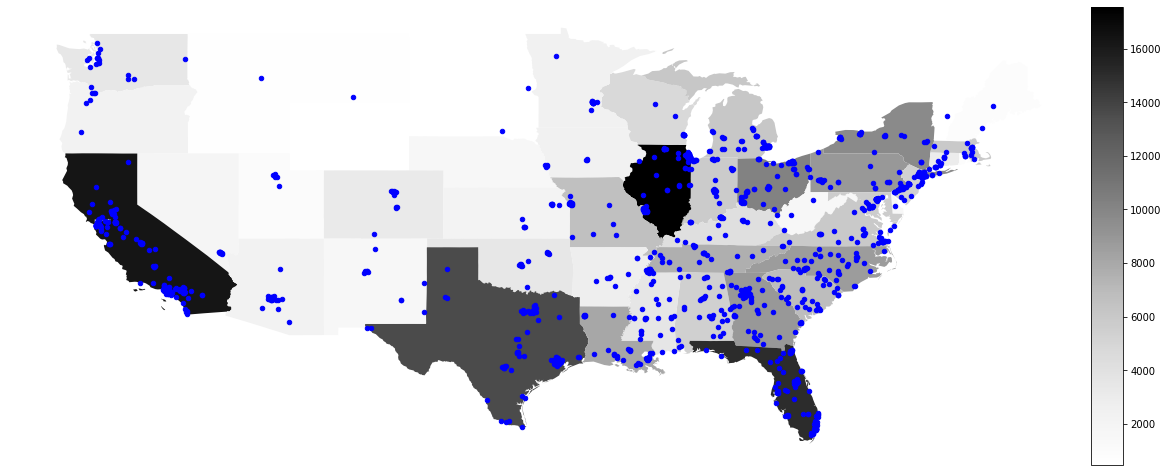

In [45]:
fig
#fig.savefig("Figures/Incidents_figure.pdf", bbox_inches='tight')

### Heatmap of number of gun restrictive laws 

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


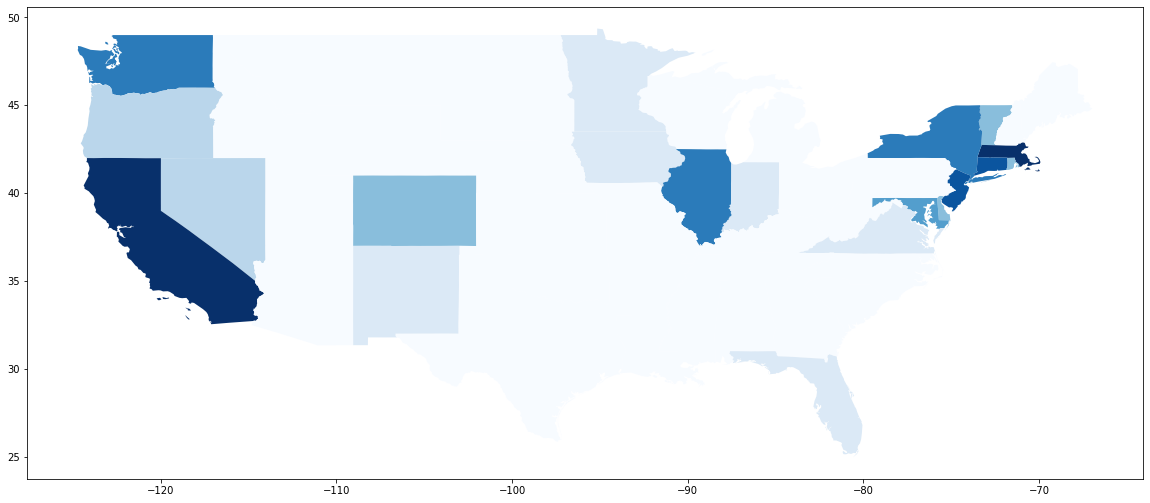

In [41]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'longgun_laws - count'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig_law, ax = plt.subplots(1, figsize=(20, 15))
merged_group_all.plot(column=variable, cmap='Blues', linewidth=0.8, ax = ax)

In [43]:
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig_law.colorbar(sm, cax=cax)

# add legend

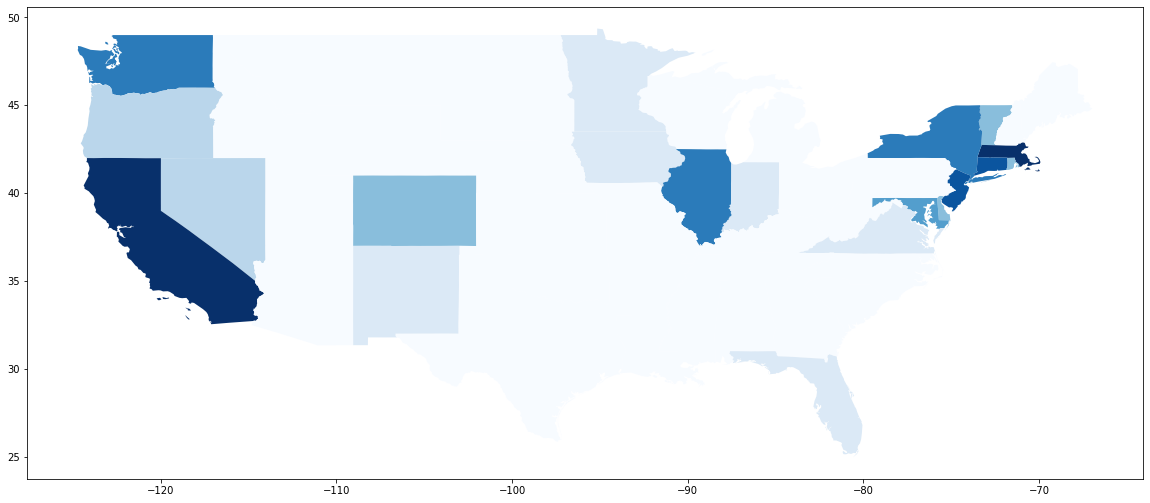

In [42]:
#fig_law.savefig("Figures/Laws_figure.pdf", bbox_inches='tight')
fig_law